# Preço de veículos com *MLBOX*

Tutorial para aplicação da biblioteca de *Auto Machine Learning MLbox* para previsão por regressão. O problema envolve a previsão de preço de veículos da marca *Hyundai*; como esse *notebook* é apenas um tutorial, irei apenas passar as principais etapas da biblioteca para o problema de regressão. 

A *MLBox* fornece os seguintes recursos:

1) Leitura rápida e pré-processamento/limpeza/formatação de dados distribuídos.

2) Seleção de *features*.

3) Otimização de hiperparâmetro precisa em espaço de alta dimensão.

4) Modelos preditivos de última geração para classificação e regressão (*Deep Learning*, *Stacking*, *LightGBM*, etc).

5) Predição com interpretação de modelos.

Os dados com as variáveis e os preços de carros podem ser obtidos [aqui](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) e documentação dessa biblioteca pode ser encontrada [aqui](https://mlbox.readthedocs.io/en/latest/).

### Instalação e importação das bibliotecas

In [160]:
pip install mlbox

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

from scipy.stats import skew, trim_mean, iqr
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera

from sklearn.metrics import mean_absolute_error, mean_squared_error,median_absolute_error, r2_score
plt.style.use('ggplot')

## Conhecendo a base de dados.

In [162]:
carro = pd.read_csv("hyundi.csv")

Primeiras observações da base de dados.

In [163]:
carro.head()

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


Últimas observações da base de dados.

In [164]:
carro.tail()

,model,year,price,transmission,mileage,fuelType,tax(£),mpg,engineSize
4855,I30,2016,8680,Manual,25906,Diesel,0,78.4,1.6
4856,I40,2015,7830,Manual,59508,Diesel,30,65.7,1.7
4857,I10,2017,6830,Manual,13810,Petrol,20,60.1,1.0
4858,Tucson,2018,13994,Manual,23313,Petrol,145,44.8,1.6
4859,Tucson,2016,15999,Automatic,11472,Diesel,125,57.6,1.7


Dimensão da base de dados.

In [165]:
carro.shape

(4860, 9)

Tipo dos dados.

In [166]:
carro.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax(£)            int64
mpg             float64
engineSize      float64
dtype: object

Convertendo os dados inteiros para *float64*.

In [167]:
for i in carro.select_dtypes('int64').columns:
  carro[i] = carro[i].astype('float64')

O coeficiente de correlação entre as *features* mostra uma relação fraca.

In [168]:
carro.corr()['price']

year          0.575765
price         1.000000
mileage      -0.443576
tax(£)        0.321028
mpg          -0.320355
engineSize    0.522384
Name: price, dtype: float64

Tabela estatística da base de dados.

In [169]:
carro.describe()

,year,price,mileage,tax(£),mpg,engineSize
count,4860.000000,4860.00000,4860.000000,4860.000000,4860.000000,4860.000000
mean,2017.107613,12750.13107,21486.049588,121.147119,53.827798,1.457922
std,1.920456,5992.92231,17710.196964,58.003289,12.736042,0.400788
min,2000.000000,1200.00000,1.000000,0.000000,1.100000,0.000000
25%,2016.000000,8000.00000,8339.250000,125.000000,44.800000,1.200000
50%,2017.000000,11990.00000,17462.000000,145.000000,55.400000,1.600000
75%,2019.000000,15733.75000,30967.000000,145.000000,60.100000,1.700000
max,2020.000000,92000.00000,138000.000000,555.000000,256.800000,2.900000


Identificando *outliers*.

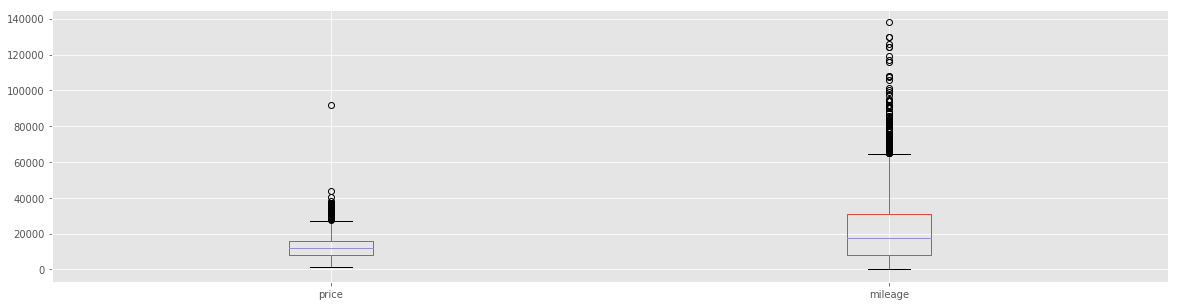

In [170]:
carro[['price','mileage']].plot.box(figsize=(20,5));

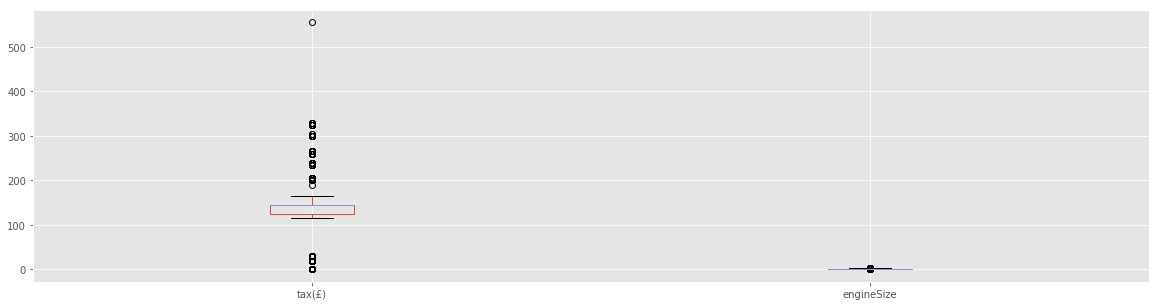

In [171]:
carro[['tax(£)','engineSize']].plot.box(figsize=(20,5));

Excluindo os *outliers*.

In [173]:
#definindo os quartis
q1p,q3p = np.percentile(carro['price'], [25,75])
#ntervalo Interquartil
intervalo_qr = iqr(carro['price'])
#limites inferiores e superiores
limite_inferior_price = q1p-(intervalo_qr*1.5)
limite_superior_price = q3p+(intervalo_qr*1.5)

#definindo os quartis
q1m,q3m = np.percentile(carro['mileage'], [25,75])
#ntervalo Interquartil
intervalo_qr2 = iqr(carro['mileage'])
#limites inferiores e superiores
limite_inferior_mileage = q1m-(intervalo_qr2*1.5)
limite_superior_mileage = q3m+(intervalo_qr2*1.5)

In [200]:
carro = carro.drop(carro[carro['price']>limite_superior_price].index)
carro = carro.drop(carro[carro['mileage']>limite_superior_mileage].index)

In [201]:
#SUBSTITUINDO OS OUTLIERS PELA MÉDIA (OU MEDIANA)
#for x in carro:
 #   carro['price'] = np.where(carro['price'] > limite_superior_price, limite_superior_price, carro['price'])
  #  carro['mileage'] = np.where(carro['mileage'] > limite_superior_mileage, limite_superior_mileage, carro['mileage'])

Separando as *features* e a variável *target*. Além disso exclui as variáveis do tipo objeto.

In [202]:
X = carro.drop(['price','model','transmission','fuelType'], axis=1)
y = carro['price']

In [203]:
carro.shape

(4618, 9)

Separando os dados de treino e teste.

In [204]:
treino, teste, y_treino, y_teste = train_test_split(X, y,test_size=0.2,random_state=42)

Para a base de treino a variável de preço precisa fazer parte do *dataset*.

In [205]:
treino['price']=y_treino
#teste['price'] = y_teste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Base de treino.

In [206]:
treino

,year,mileage,tax(£),mpg,engineSize,price
3459,2018.0,14985.0,145.0,60.1,1.0,7281.0
2737,2017.0,49081.0,20.0,62.8,1.0,7995.0
521,2017.0,30000.0,145.0,74.3,1.6,13995.0
403,2018.0,19001.0,145.0,52.3,1.0,12998.0
4609,2016.0,55000.0,235.0,42.8,2.2,17490.0
...,...,...,...,...,...,...
4639,2018.0,25637.0,150.0,35.3,1.6,13700.0
480,2016.0,23793.0,30.0,61.7,1.7,12998.0
3197,2018.0,26799.0,145.0,60.1,1.0,7495.0
3915,2013.0,25976.0,260.0,41.5,2.2,15739.0


Base de teste.

In [207]:
teste

,year,mileage,tax(£),mpg,engineSize
3660,2018.0,15395.0,150.0,60.1,1.0
4536,2016.0,10618.0,30.0,55.4,1.2
3859,2017.0,30067.0,145.0,44.8,1.6
23,2016.0,7447.0,30.0,57.6,1.2
1896,2018.0,29890.0,145.0,39.8,1.6
...,...,...,...,...,...
2565,2019.0,3000.0,145.0,49.6,1.0
2098,2016.0,11000.0,145.0,47.9,1.2
2032,2018.0,33026.0,145.0,57.7,1.7
2186,2019.0,9616.0,145.0,36.2,1.6


Covertendo as bases para o formato *csv*.

In [208]:
treino.to_csv('treino.csv', index=False)
teste.to_csv('teste.csv',index=False)

## Modelagem com *MLBOX*

Definindo o *path* para ser usado na biblioteca.

In [209]:
dados = ['treino.csv','teste.csv']
alvo = 'price'

Realizando o *train_test_split* dos dados.

In [210]:
carro_df=Reader(sep=",",to_path = 'save', verbose = True).train_test_split(dados,alvo)


reading csv : treino.csv ...
cleaning data ...
CPU time: 4.740772247314453 seconds

reading csv : teste.csv ...
cleaning data ...
CPU time: 0.038465023040771484 seconds

> Number of common features : 5

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 5
> Number of training samples : 3640
> Number of test samples : 924

> You have no missing values on train set...

> Task : regression
count     3640.000000
mean     12352.264011
std       4914.350770
min       1295.000000
25%       8000.000000
50%      11980.000000
75%      15498.000000
max      26999.000000
Name: price, dtype: float64


Objeto criado.

In [211]:
carro_df

{'target': 0        7281.0
 1        7995.0
 2       13995.0
 3       12998.0
 4       17490.0
          ...   
 3689    13700.0
 3690    12998.0
 3691     7495.0
 3692    15739.0
 3693     6610.0
 Name: price, Length: 3640, dtype: float64,
 'test':      engineSize  mileage   mpg  tax(£)    year
 0           1.0  15395.0  60.1   150.0  2018.0
 1           1.2  10618.0  55.4    30.0  2016.0
 2           1.6  30067.0  44.8   145.0  2017.0
 3           1.2   7447.0  57.6    30.0  2016.0
 4           1.6  29890.0  39.8   145.0  2018.0
 ..          ...      ...   ...     ...     ...
 919         1.0   3000.0  49.6   145.0  2019.0
 920         1.2  11000.0  47.9   145.0  2016.0
 921         1.7  33026.0  57.7   145.0  2018.0
 922         1.6   9616.0  36.2   145.0  2019.0
 923         2.0  54076.0  51.4   165.0  2015.0
 
 [924 rows x 5 columns],
 'train':       engineSize  mileage   mpg  tax(£)    year
 0            1.0  14985.0  60.1   145.0  2018.0
 1            1.0  49081.0  62.8    20.0 

Reaizando o pré-processamento.

In [212]:
carro_df = Drift_thresholder().fit_transform(carro_df)


computing drifts ...
CPU time: 0.13710713386535645 seconds

> Top 10 drifts

('engineSize', 0.048441439512868056)
('year', 0.0424325674325674)
('tax(£)', 0.017189358260786936)
('mpg', 0.012973336187621864)
('mileage', 0.0061723990295419195)

> Deleted variables : []
> Drift coefficients dumped into directory : save


Otimização do modelo.

Abaixo é uma otimização de modelo sem a inserção de parâmetros.

In [213]:
Optimiser().evaluate(None, carro_df)

/usr/local/lib/python3.7/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : neg_mean_squared_error = -1658835.0932478365
VARIANCE : 5772.845811283332 (fold 1 = -1653062.2474365532, fold 2 = -1664607.93905912)
CPU time: 1.0483653545379639 seconds


-1658835.0932478365

Definindo parâmetros.

In [214]:
parametros = {

        'ne__numerical_strategy' : {"space" : [0, 'mean']},

        #'ce__strategy' : ["label_encoding", "random_projection", "entity_embedding"],

        'fs__strategy' : {"space" : ["variance", "rf_feature_importance"]},
        'fs__threshold': {"search" : "choice", "space" : [0.1, 0.2, 0.3]},

        'est__strategy' : {"space" : ["LightGBM"]},
        'est__max_depth' : {"search" : "choice", "space" : [5,6]},
        'est__subsample' : {"search" : "uniform", "space" : [0.6,0.9]}

        }

Escolhendo os melhores parâmetros para o modelo.

In [215]:
melhores_parametros = Optimiser().optimise(parametros, carro_df)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.1}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'subsample': 0.7730973094809753, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.7/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


MEAN SCORE : neg_mean_squared_error = -1671854.563974319
VARIANCE : 52588.14096095157 (fold 1 = -1619266.4230133675, fold 2 = -1724442.7049352706)
CPU time: 1.4623510837554932 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> FEATURE SELECTOR :{'strategy': 'rf_feature_importance', 'threshold': 0.3}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'subsample': 0.7867277380394324, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq'

Melhores parâmetros.

In [216]:
melhores_parametros

{'est__max_depth': 6,
 'est__strategy': 'LightGBM',
 'est__subsample': 0.7730973094809753,
 'fs__strategy': 'rf_feature_importance',
 'fs__threshold': 0.1,
 'ne__numerical_strategy': 'mean'}

Gerando as previsões: aqui irei inserir a relação de parâmetros acima que irão otimizar o modelo para gerar os melhores resultados possíveis.


fitting the pipeline ...
CPU time: 0.8958477973937988 seconds


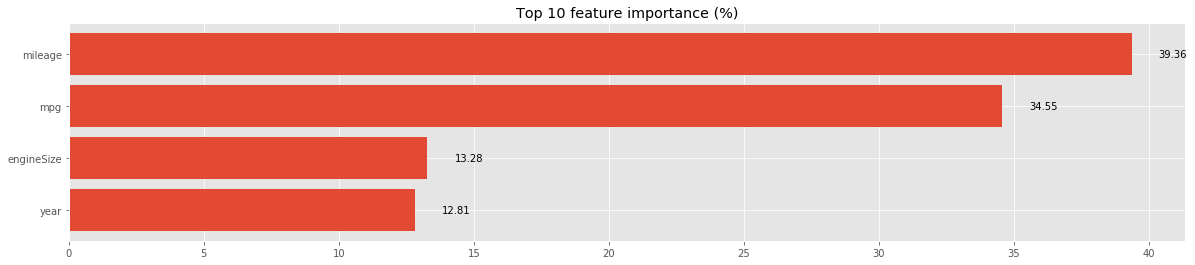


> Feature importances dumped into directory : save

predicting...
CPU time: 0.04619169235229492 seconds

> Overview on predictions : 

   price_predicted
0      7691.033464
1      8318.371750
2     12762.089390
3      8461.338190
4     16511.829133
5     17723.970928
6     24406.635860
7      9699.345187
8      6099.412978
9     12957.870465

dumping predictions into directory : save ...


In [217]:
prd = Predictor()
predictions = prd.fit_predict(melhores_parametros, carro_df)

Ao serem geradas as previsões é criada no diretório do projeto um pasta com o nome *save* e dentro dela contém a imagem gerada acima e as previsões no formato *csv*.

In [219]:
previsoes = pd.read_csv('price_predictions.csv')
previsoes['Valores reais'] = y_teste.tolist()
previsoes

,Unnamed: 0,price_predicted,Valores reais
0,0,7691.033464,7291.0
1,1,8318.371750,8399.0
2,2,12762.089390,11399.0
3,3,8461.338190,8100.0
4,4,16511.829133,16990.0
...,...,...,...
919,919,9955.296201,8990.0
920,920,8912.376658,7995.0
921,921,16356.986414,17190.0
922,922,20576.452366,17990.0


## Comparando os resultados.

Tabela estatística dos resultados.

In [220]:
previsoes.describe()

,Unnamed: 0,price_predicted,Valores reais
count,924.000000,924.000000,924.000000
mean,461.500000,12388.643125,12398.004329
std,266.880123,4741.194602,4895.782523
min,0.000000,2842.616510,2995.000000
25%,230.750000,8331.724823,8484.500000
50%,461.500000,12147.892060,11998.000000
75%,692.250000,15562.392662,15499.000000
max,923.000000,25057.774471,27000.000000


Gráfico de dispersão com a reta de regressão.

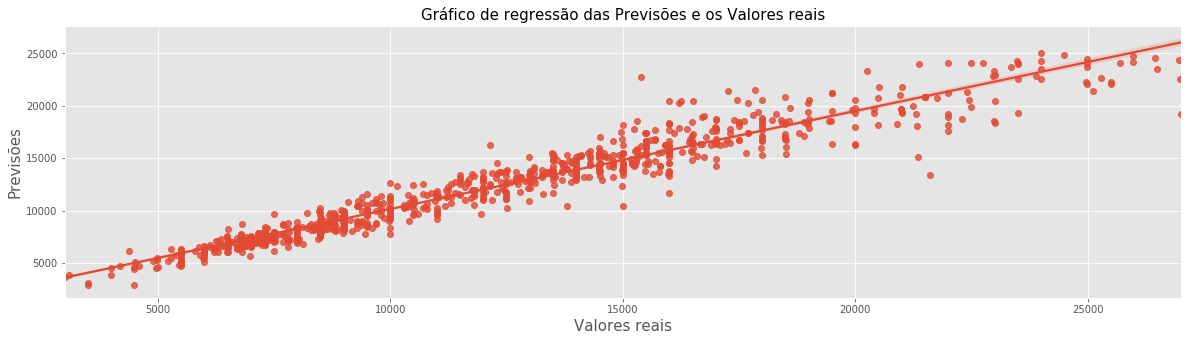

In [221]:
plt.figure(figsize=(20,5))
sns.regplot(x='Valores reais', y='price_predicted', data = previsoes)
plt.title('Gráfico de regressão das Previsões e os Valores reais', size=15)
plt.xlabel('Valores reais',size=15)
plt.ylabel('Previsões',size=15);

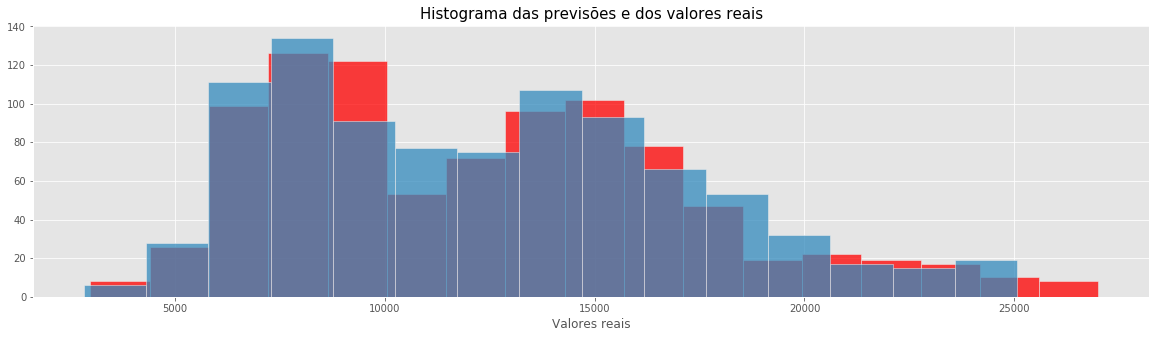

In [222]:
plt.figure(figsize=(20,5))
sns.histplot(x='Valores reais', data = previsoes, color='red')
sns.histplot(x='price_predicted', data = previsoes)
plt.title('Histograma das previsões e dos valores reais', size=15)
plt.ylabel('');

Métricas de avaliação do modelo.

In [223]:
print('Erro médio absoluto :',mean_absolute_error(previsoes['price_predicted'],previsoes['Valores reais']))
print('Erro quadrado médio absoluto :',mean_squared_error(previsoes['price_predicted'],previsoes['Valores reais']))
print('Erro mediano absoluto :',median_absolute_error(previsoes['price_predicted'],previsoes['Valores reais']))
print('Coeficiente de determinação (R²) :',r2_score(previsoes['price_predicted'],previsoes['Valores reais']))

Erro médio absoluto : 857.3905049511437
Erro quadrado médio absoluto : 1591912.1801324103
Erro mediano absoluto : 594.970859626219
Coeficiente de determinação (R²) : 0.9291052927814103


Análise dos resíduos.

Notar a presença de 2 *outliers* nos resíduos e que provavlemente estão impactando nos gráficos abaixo.

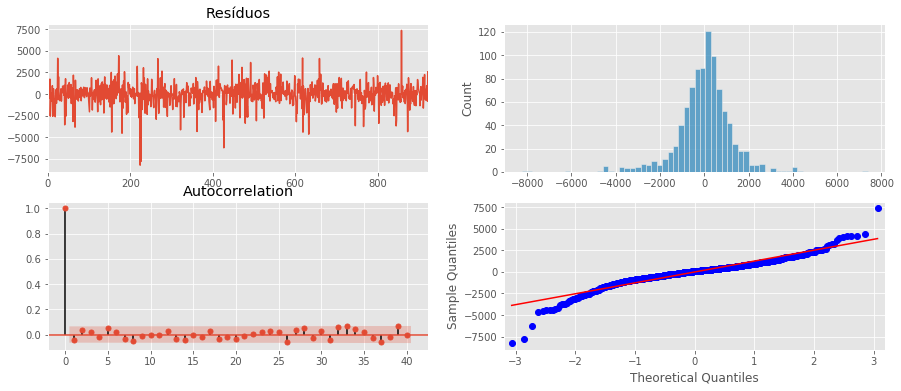

In [224]:
residuals = previsoes['price_predicted']-previsoes['Valores reais']
fig, ax = plt.subplots(2,2,figsize=(15,6))
residuals.plot(title="Resíduos", ax=ax[0][0])
sns.histplot(residuals,ax=ax[0][1])
plot_acf(residuals,lags=40, ax=ax[1][0])
qqplot(residuals,line='s', ax=ax[1][1]);